In [1]:
import numpy as np
import pandas as pd
import xarray as xa
from matplotlib import pyplot as plt
import pandas as pd
from scipy.stats import bootstrap

In [2]:
def start_end_time(sub_id):
    start = []
    end = []
    ext_times = ext_days[sub_id]
    length = len(ext_times)
    i = 0
    while i <= length - 1:
        j = 1
        while (j + i <= length - 1) and ((ext_times[i + j] - ext_times[i + j - 1]) / np.timedelta64(1, 'D') == 1):
            j += 1
        start.append(ext_times[i] - np.timedelta64(12, 'h'))
        end.append(ext_times[i + j - 1] + np.timedelta64(12, 'h'))
        i += j
    return start, end


def is_monsoon_precip(month):
    return (month <= 9) & (month >= 6)

In [3]:
data = xa.open_dataarray("/tempest/duan0000/exprecip/cpc-global/NAM_sub_precip")  # CPC
monsoon_precip = data.sel(time=(is_monsoon_precip(data.time.dt.month)))
monsoon_precip = monsoon_precip.sel(time=(monsoon_precip.time.dt.year < 2019))
del data
ext_days = {}
for sub_id in range(1, 8):
    print("sub_id: ", sub_id)
    precip = monsoon_precip.sel(sub_id=sub_id)
    precip_data = precip.data
    q1 = np.quantile(precip_data[precip_data > 1], 0.05)
    q2 = np.quantile(precip_data[precip_data > 1], 0.95)
    ext_time = precip.where(precip > q2, drop=True).time.data
    print(len(ext_time), q2)
    ext_days[sub_id] = ext_time

sub_id:  1
39 21.363590636973544
sub_id:  2
38 7.98353434112839
sub_id:  3
37 7.6309751208430425
sub_id:  4
77 6.2968948209451305
sub_id:  5
118 6.469523059079158
sub_id:  6
124 10.647874758983226
sub_id:  7
153 17.252742222601025


In [4]:
class Surge:
    def __init__(self, start_time, end_time):
        self.start_time = start_time
        self.end_time = end_time
        self.length = (end_time-start_time)/np.timedelta64(1, 'h')
def load_Surge():
    surge_data_6h = "/tempest/duan0000/exprecip/nam_ivt/MoistureSurge-6h.nc"
    surge_data_6h = xa.open_dataset(surge_data_6h)
    print('SURGE: ', surge_data_6h)

    surge_record_6h = []
    for i in range(529):
        surge = Surge(start_time=surge_data_6h.start_time.data[i], end_time=surge_data_6h.end_time.data[i])
        surge_record_6h.append(surge)
    return surge_record_6h
surge = load_Surge()
print(len(surge))

SURGE:  <xarray.Dataset>
Dimensions:     (index: 529)
Coordinates:
  * index       (index) int64 0 1 2 3 4 5 6 7 ... 522 523 524 525 526 527 528
Data variables:
    start_time  (index) datetime64[ns] ...
    end_time    (index) datetime64[ns] ...
529


12.0   6.0   192.0   29.705103969754255
1979-07-15T12:00:00.000000000   1979-07-16T18:00:00.000000000


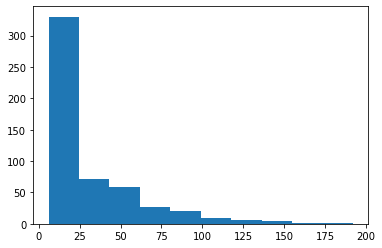

In [5]:
surge_length = []
for s in surge:
    surge_length.append(s.length)
print(np.median(surge_length), ' ', np.min(surge_length), ' ', np.max(surge_length), ' ', np.mean(surge_length))
plt.hist(surge_length)
print(surge[0].start_time, ' ', surge[0].end_time)

# Precip anomaly composites

In [6]:
def surge_com(sub_id):
    precip_sub = monsoon_precip.sel(sub_id=sub_id) # daily
    month_date = precip_sub.time.dt.strftime("%m-%d")
    precip_sub = precip_sub.assign_coords(month_date=("time", month_date.data))
    precip_sub_climate = precip_sub.groupby(precip_sub.month_date).mean()
    precip_anomaly = precip_sub.groupby(precip_sub.month_date) - precip_sub_climate
    precip_com = []
    for s in surge:
        start = s.start_time
        start = pd.to_datetime(start)
        day = start.day
        month = start.month
        year = start.year
        timeindex = np.datetime64(str(year)+'-'+str(month).zfill(2)+'-'+str(day).zfill(2))
        if start.hour>12:
            timeindex += np.timedelta64(1, 'D')
        if pd.to_datetime(timeindex+np.timedelta64(7 ,'D')).month<=9 and pd.to_datetime(timeindex-np.timedelta64(7 ,'D')).month>=6:
            precip_com.append(precip_anomaly.sel(time=slice(timeindex-np.timedelta64(7 ,'D'), timeindex+np.timedelta64(7 ,'D'))).data.reshape(-1, 1))
    print(len(precip_com))
    return precip_com

500
[ 0.01117228 -0.08775086  0.01938473  0.02342278 -0.11666787 -0.18923402
  0.0287913   0.1032275   0.66151052  1.05405706  0.54342068  0.11471746
 -0.12647556 -0.16363206 -0.13419414]


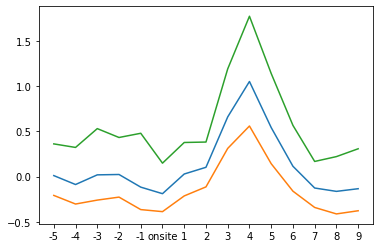

In [7]:
precip_com = surge_com(1)
precip_com = np.concatenate(precip_com, axis=1)
precip_com_mean = np.mean(precip_com, axis=1)
print(precip_com_mean)
lower = []
upper = []
for i in range(15):
    x_mean = bootstrap((precip_com[i].reshape(-1), ), np.mean)
    lower.append(x_mean.confidence_interval[0])
    upper.append(x_mean.confidence_interval[1])
plt.plot(precip_com_mean)
plt.plot(lower)
plt.plot(upper)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 
           ['-5', '-4', '-3', '-2', '-1', 'onsite', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
plt.show()

500
[-0.04603381  0.00199758  0.00503141  0.05999295 -0.10675964 -0.08328436
 -0.00785873  0.07721536  0.4608488   0.4019859   0.23185079  0.23352061
  0.22179052  0.18782385  0.22824052]


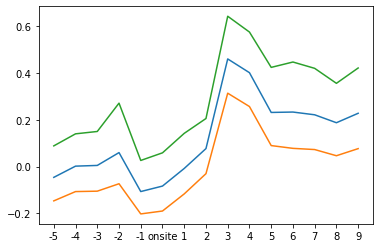

In [8]:
precip_com = surge_com(2)
precip_com = np.concatenate(precip_com, axis=1)
precip_com_mean = np.mean(precip_com, axis=1)
print(precip_com_mean)
lower = []
upper = []
for i in range(15):
    x_mean = bootstrap((precip_com[i].reshape(-1), ), np.mean)
    lower.append(x_mean.confidence_interval[0])
    upper.append(x_mean.confidence_interval[1])
plt.plot(precip_com_mean)
plt.plot(lower)
plt.plot(upper)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 
           ['-5', '-4', '-3', '-2', '-1', 'onsite', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
plt.show()

500
[-0.00234628 -0.00321595  0.01221405 -0.08763786 -0.16949847 -0.19040502
 -0.13060859  0.02956107  0.35174533  0.45879539  0.30290894  0.26747837
  0.2047369   0.22390318  0.19467926]


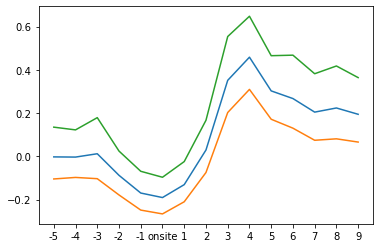

In [9]:
precip_com = surge_com(3)
precip_com = np.concatenate(precip_com, axis=1)
precip_com_mean = np.mean(precip_com, axis=1)
print(precip_com_mean)
lower = []
upper = []
for i in range(15):
    x_mean = bootstrap((precip_com[i].reshape(-1), ), np.mean)
    lower.append(x_mean.confidence_interval[0])
    upper.append(x_mean.confidence_interval[1])
plt.plot(precip_com_mean)
plt.plot(lower)
plt.plot(upper)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 
           ['-5', '-4', '-3', '-2', '-1', 'onsite', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
plt.show()

500
[ 0.03059176  0.10494519  0.04299759  0.06218711 -0.10981743 -0.2166143
 -0.181174   -0.06554744  0.0683713   0.32302301  0.25398505  0.21351134
  0.27012001  0.22021418  0.16605898]


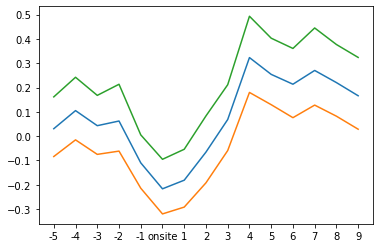

In [10]:
precip_com = surge_com(4)
precip_com = np.concatenate(precip_com, axis=1)
precip_com_mean = np.mean(precip_com, axis=1)
print(precip_com_mean)
lower = []
upper = []
for i in range(15):
    x_mean = bootstrap((precip_com[i].reshape(-1), ), np.mean)
    lower.append(x_mean.confidence_interval[0])
    upper.append(x_mean.confidence_interval[1])
plt.plot(precip_com_mean)
plt.plot(lower)
plt.plot(upper)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 
           ['-5', '-4', '-3', '-2', '-1', 'onsite', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
plt.show()

500
[ 0.02484898  0.06922565  0.02144544 -0.04938794 -0.03649358 -0.13220051
 -0.14947883 -0.05476757  0.26046127  0.36632694  0.3750041   0.34145786
  0.27968131  0.18945048  0.12218084]


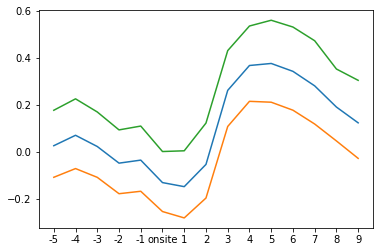

In [11]:
precip_com = surge_com(5)
precip_com = np.concatenate(precip_com, axis=1)
precip_com_mean = np.mean(precip_com, axis=1)
print(precip_com_mean)
lower = []
upper = []
for i in range(15):
    x_mean = bootstrap((precip_com[i].reshape(-1), ), np.mean)
    lower.append(x_mean.confidence_interval[0])
    upper.append(x_mean.confidence_interval[1])
plt.plot(precip_com_mean)
plt.plot(lower)
plt.plot(upper)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 
           ['-5', '-4', '-3', '-2', '-1', 'onsite', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
plt.show()

500
[ 0.20441014 -0.12731201  0.01035606 -0.00747215 -0.01547059  0.10011836
  0.23354576  0.49995862  0.547703    0.5884684   0.7285104   0.55324552
  0.38828995  0.23103872  0.16313   ]


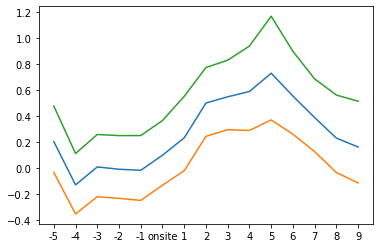

In [12]:
precip_com = surge_com(6)
precip_com = np.concatenate(precip_com, axis=1)
precip_com_mean = np.mean(precip_com, axis=1)
print(precip_com_mean)
lower = []
upper = []
for i in range(15):
    x_mean = bootstrap((precip_com[i].reshape(-1), ), np.mean)
    lower.append(x_mean.confidence_interval[0])
    upper.append(x_mean.confidence_interval[1])
plt.plot(precip_com_mean)
plt.plot(lower)
plt.plot(upper)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 
           ['-5', '-4', '-3', '-2', '-1', 'onsite', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
plt.show()

500
[ 0.29283011  0.3460871   0.05110053 -0.00339766  0.27610126  0.44641972
  0.65717455  0.87651055  0.39536621  0.78907572  0.84327466  0.34695313
  0.15762666  0.01993604  0.1992397 ]


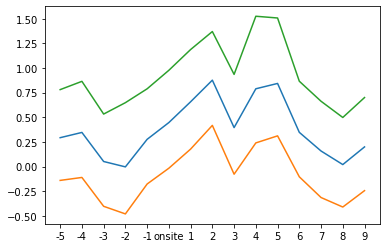

In [13]:
precip_com = surge_com(7)
precip_com = np.concatenate(precip_com, axis=1)
precip_com_mean = np.mean(precip_com, axis=1)
print(precip_com_mean)
lower = []
upper = []
for i in range(15):
    x_mean = bootstrap((precip_com[i].reshape(-1), ), np.mean)
    lower.append(x_mean.confidence_interval[0])
    upper.append(x_mean.confidence_interval[1])
plt.plot(precip_com_mean)
plt.plot(lower)
plt.plot(upper)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 
           ['-5', '-4', '-3', '-2', '-1', 'onsite', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
plt.show()

500
500
500
500
500
500
500


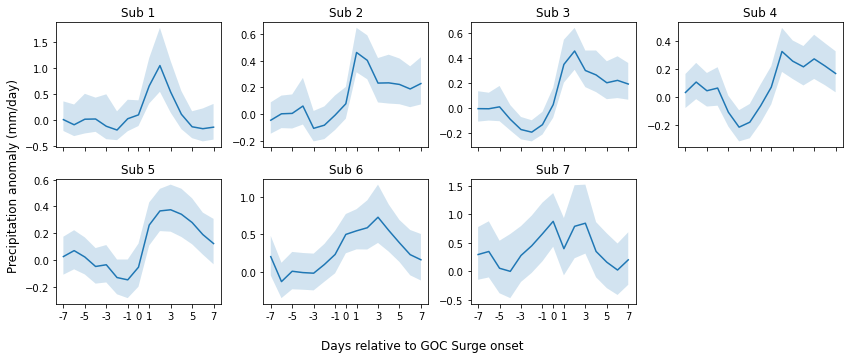

In [17]:
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(12, 5), sharex=True, sharey=False)
for sub in range(1, 8):
    precip_com = surge_com(sub)
    precip_com = np.concatenate(precip_com, axis=1)
    precip_com_mean = np.mean(precip_com, axis=1)
    lower = []
    upper = []
    ax = axes.flatten()[sub-1]
    for i in range(15):
        x_mean = bootstrap((precip_com[i].reshape(-1), ), np.mean)
        lower.append(x_mean.confidence_interval[0])
        upper.append(x_mean.confidence_interval[1])
    ax.plot(precip_com_mean)
    ax.fill_between(np.arange(15), y1=lower, y2=upper, alpha=0.2)
    ax.set_title('Sub '+str(sub), fontsize=12)
    ax.set_xticks([0, 2, 4, 6, 7, 8, 10, 12, 14])
    ax.set_xticklabels(['-7', '-5', '-3', '-1', '0', '1', '3', '5', '7'])
fig.delaxes(axes[1][3])
fig.supylabel('Precipitation anomaly (mm/day)', fontsize=12)
fig.supxlabel('Days relative to GOC Surge onset', fontsize=12)
plt.tight_layout()
plt.savefig('surge_compo.png', dpi=150, bbox_inches='tight')
plt.show()